# Comparison of aviation climate models

In [1]:
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from climate_models.fair_climate_model import background_species_quantities_function
from climate_models.climate_models import aviation_climate_model

## Parameters

In [2]:
commercial_aviation_historical_data_df = read_csv("climate_data/temperature_historical_dataset.csv", delimiter=";", header=None)
commercial_aviation_historical_data = commercial_aviation_historical_data_df.values
years_data = commercial_aviation_historical_data[:, 0]
co2_emissions_data = commercial_aviation_historical_data[:, 1]
nox_emissions_data = commercial_aviation_historical_data[:, 2]
h2o_emissions_data = commercial_aviation_historical_data[:, 3]
soot_emissions_data = commercial_aviation_historical_data[:, 4]
sulfur_emissions_data = commercial_aviation_historical_data[:, 5]
distance_data = commercial_aviation_historical_data[:, 6]

start_year = int(years_data[0])
end_year = int(years_data[-1])

species_quantities = np.zeros((7,len(years_data)))
species_quantities[0] = co2_emissions_data * 1e9 # [Mt to kg]
species_quantities[1] = distance_data
species_quantities[2] = nox_emissions_data * 1e9 # [Mt to kg]
species_quantities[3] = nox_emissions_data * 1e9 # [Mt to kg]
species_quantities[4] = h2o_emissions_data * 1e9 # [Mt to kg]
species_quantities[5] = soot_emissions_data * 1e9 # [Mt to kg]
species_quantities[6] = sulfur_emissions_data * 1e9 # [Mt to kg]

In [3]:
background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
sensitivity_erf_gwpstar = [0, 9.36e-13, 34.4e-12 * (14/46), -30.8e-12 * (14/46), 0.0052e-12, 100.7e-12, -19.9e-12]
sensitivity_erf_other = [0, 9.36e-13, 34.4e-12 * (14/46), -0.82e-9, 0.0052e-12, 100.7e-12, -19.9e-12]
ratio_erf_rf = [1, 0.42, 1.37, 1.18, 1, 1, 1]
efficacy_erf = [1, 1, 1, 1, 1, 1, 1]
tcre = 0.00045

params_gwpstar = {"sensitivity_erf": sensitivity_erf_gwpstar, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf, "tcre": tcre}
params_lwe = {"sensitivity_erf": sensitivity_erf_other, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf, "tcre": tcre}
params_fair = {"background_species_quantities": background_species_quantities, "sensitivity_erf": sensitivity_erf_other, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}

## Calculation

In [4]:
temperature_increase_from_aviation_gwpstar = aviation_climate_model(start_year, end_year, "GWP*", species_quantities, params_gwpstar)[-1]
temperature_increase_from_aviation_lwe = aviation_climate_model(start_year, end_year, "LWE", species_quantities, params_lwe)[-1]
temperature_increase_from_aviation_fair = aviation_climate_model(start_year, end_year, "FaIR", species_quantities, params_fair)[-1]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/60 [00:00<?, ?timesteps/s]

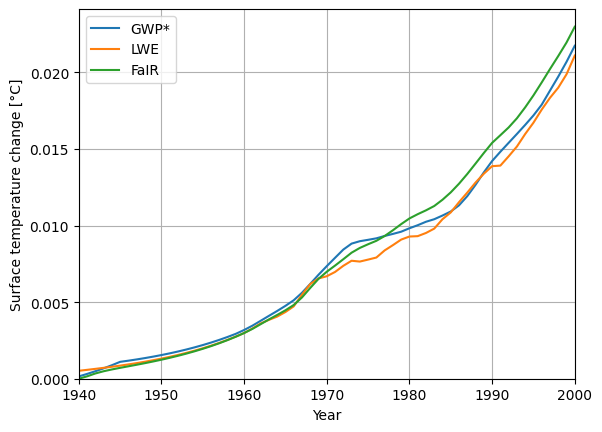

In [5]:
plt.plot(years_data, temperature_increase_from_aviation_gwpstar, label='GWP*')
plt.plot(years_data, temperature_increase_from_aviation_lwe, label='LWE')
plt.plot(years_data, temperature_increase_from_aviation_fair, label='FaIR')
plt.xlabel('Year')
plt.ylabel('Surface temperature change [°C]')
plt.grid()
plt.xlim(1940,2000)
plt.ylim(0,)
plt.legend()